In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Activation,Convolution2D
from keras.layers import Input, Add, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, add, concatenate, Lambda
from keras.datasets import mnist
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as k
from keras.optimizers import Adam
from PIL import Image as pil_image
from keras.models import Model
from PIL import Image as pil_image
import cv2 as cv2
from  skimage import transform
from keras.datasets import cifar10
from keras.datasets import mnist
from keras import optimizers

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# a = []
# while(1):
#     a.append(1)

11493376/11490434 [==============================] - 1s 0us/step
Training data Dimension :  (60000, 28, 28) (60000,)
Testing data Dimension :  (10000, 28, 28) (10000,)
10
Original label :  3
After One Hot Encoding :  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


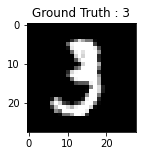

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training data Dimension : ', x_train.shape, y_train.shape)
print('Testing data Dimension : ', x_test.shape, y_test.shape)
classes = np.unique(y_train)
number_of_classes = len(classes)
print(number_of_classes)

plt.figure(figsize=[2,2])
plt.imshow(x_train[10,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[10]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train_one_hot = keras.utils.to_categorical(y_train, number_of_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, number_of_classes)

print('Original label : ', y_train[10])
print('After One Hot Encoding : ', y_train_one_hot[10])

In [ ]:
rows, cols = 28,28
ch=1
if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], ch, rows, cols)
    x_test = x_test.reshape(x_test.shape[0], ch, rows, cols)
    input_shape = (ch, rows, cols)
else:
    x_train = x_train.reshape(x_train.shape[0],rows, cols,ch)
    x_test = x_test.reshape(x_test.shape[0], rows, cols,ch)
    input_shape = ( rows, cols, ch)
print(input_shape)

(28, 28, 1)


In [ ]:
def convolution_2d(signal, NumberOfFilters, FilterSize, Stride, Padding, Name, NonLinearActivation): #,data_format='channels_first'

  signal = Conv2D(NumberOfFilters, kernel_size = FilterSize, strides = Stride, padding = Padding, kernel_initializer=keras.initializers.he_normal(seed=0), name = Name+ 'Conv2D')(signal)
  signal = BatchNormalization(axis=ch, name = Name +'Batch_Normalization')(signal)

  if (NonLinearActivation):
    signal = Activation('relu', name = Name+'ReLU_Activation')(signal)

  return (signal)

In [ ]:
def Inception_Block_A (signal,Name):

  img = signal
  signal1 = convolution_2d (signal, 32, 1, Stride=1, Padding='valid', Name = Name + 'signal1_1x1', NonLinearActivation = True)
           
  signal2 = convolution_2d (signal, 32, 1, Stride=1,  Padding='valid', Name = Name + 'signal2_1x1', NonLinearActivation = True)
  signal2 = convolution_2d (signal2, 32, 3, Stride=1, Padding='same',  Name = Name + 'signal2_3x3', NonLinearActivation = True)

  signal3 = convolution_2d (signal, 32, 1, Stride=1, Padding='valid', Name = Name + 'signal3_1x1', NonLinearActivation = True)
  signal3 = convolution_2d (signal3, 48, 3, Stride=1, Padding='same', Name = Name + 'signal3_3x3_1', NonLinearActivation = True)
  signal3 = convolution_2d (signal3, 64, 3, Stride=1, Padding='same', Name = Name + 'signal3_3x3_2', NonLinearActivation = True)

  merge_layer = concatenate([signal1, signal2, signal3], name = Name+'Concatinate')

  one_one_conv = convolution_2d (merge_layer, 384, 1, Stride = 1, Padding='valid', Name = Name + '1x1_Conv', NonLinearActivation = False )
  #residual_connection = add([signal , one_one_conv], name= Name + 'Skip_Connection')
    
  residual_connection = Lambda(lambda vector: vector[0] + vector[1] * .10)([signal, one_one_conv])
  Residual_Layer = Activation('relu')(residual_connection)

  return Residual_Layer

In [ ]:
def Inception_Block_B (signal,Name):

  signal1 = convolution_2d (signal, 192, 1, Stride=1, Padding='valid', Name = Name + 'signal1_1x1', NonLinearActivation = True)

  signal2 = convolution_2d (signal, 128, 1, Stride=1,  Padding='valid', Name = Name + 'signal2_1x1', NonLinearActivation = True)
  signal2 = convolution_2d (signal2, 160, [1,7], Stride=1, Padding='same',  Name = Name + 'signal2_1x7', NonLinearActivation = True)
  signal2 = convolution_2d (signal2, 192, [7,1], Stride=1, Padding='same',  Name = Name + 'signal2_7x1', NonLinearActivation = True)

  merge_layer = concatenate([signal1,signal2], name = Name + 'Concatinate')
  one_one_conv = convolution_2d (merge_layer, 1024, 1, Stride = 1, Padding='valid', Name = Name + '1x1_Conv', NonLinearActivation = False )

  #residual_connection = add([signal , one_one_conv], name= Name + 'Skip_Connection')

  residual_connection = Lambda(lambda vector: vector[0] + vector[1] * .10)([signal, one_one_conv])
  Residual_Layer = Activation('relu')(residual_connection)
  
  return Residual_Layer

In [ ]:
def Inception_Block_C (signal,Name):
  

  signal1 = convolution_2d (signal, 192, 1, Stride=1, Padding='valid', Name = Name + 'signal1_1x1', NonLinearActivation = True)

  signal2 = convolution_2d (signal, 192, 1, Stride=1,  Padding='valid', Name = Name + 'signal2_1x1', NonLinearActivation = True)
  signal2 = convolution_2d (signal2, 224, [1,3], Stride=1, Padding='same',  Name = Name + 'signal2_1x3', NonLinearActivation = True)
  signal2 = convolution_2d (signal2, 256, [3,1], Stride=1, Padding='same',  Name = Name + 'signal2_3x1', NonLinearActivation = True)

  merge_layer = concatenate([signal1,signal2], name = Name + 'Concatinate')
  one_one_conv = convolution_2d (merge_layer, 1536, 1, Stride = 1, Padding='valid', Name = Name + '1x1_Conv', NonLinearActivation = False )

  #residual_connection = add([signal , one_one_conv], name= Name + 'Skip_Connection')
  
  residual_connection = Lambda(lambda vector: vector[0] + vector[1] * .10)([signal, one_one_conv])
  Residual_Layer = Activation('relu')(residual_connection)

  return Residual_Layer

In [ ]:
def Grid_Size_Reduction_A (signal, Name): #Fig 10 of Inception Network V3

  signal1 = MaxPooling2D(2, strides =2, padding = 'same', name = Name + 'MaxPool_for_Size_Reduction')(signal)

  signal2 = convolution_2d(signal, 256, 1, Stride=1, Padding='valid', Name = Name + 'signal2_1x1', NonLinearActivation = True )
  signal2 = convolution_2d(signal2, 256, 3, Stride=1, Padding='same', Name = Name + 'signal2_3x3_s1', NonLinearActivation = True )
  signal2 = convolution_2d(signal2, 384, 3, Stride=2, Padding='same', Name = Name + 'signal2_3x3_s2', NonLinearActivation = True )

  signal3 = convolution_2d(signal, 256, 1, Stride=1, Padding='valid', Name = Name + 'signal3_1x1', NonLinearActivation = True )
  signal3 = convolution_2d(signal, 256, 3, Stride=2, Padding='same', Name = Name + 'signal3_1x1_s2', NonLinearActivation = True )

  Grid_Size_Reduction = concatenate([signal1, signal2, signal3], name= Name+ 'Grid_Size_Reduction_A')

  return Grid_Size_Reduction

In [ ]:
def Grid_Size_Reduction_B (signal, Name): #Fig 10 of Inception Network V3

  signal1 = MaxPooling2D(2, strides =2, padding = 'valid', name = Name + 'MaxPool_for_Size_Reduction')(signal)

  signal2 = convolution_2d(signal, 256, 1, Stride=1, Padding='valid', Name = Name + 'signal2_1x1', NonLinearActivation = True )
  signal2 = convolution_2d(signal2, 256, 3, Stride=1, Padding='same', Name = Name + 'signal2_3x3_s1', NonLinearActivation = True )
  signal2 = convolution_2d(signal2, 256, 3, Stride=2, Padding='same', Name = Name + 'signal2_3x3_s2', NonLinearActivation = True )

  signal3 = convolution_2d(signal, 256, 1, Stride=1, Padding='valid', Name = Name + 'signal3_1x1', NonLinearActivation = True )
  signal3 = convolution_2d(signal, 256, 3, Stride=2, Padding='same', Name = Name + 'signal3_1x1_s2', NonLinearActivation = True )

  Grid_Size_Reduction = concatenate([signal1, signal2, signal3], name= Name+ 'Grid_Size_Reduction_A')

  return Grid_Size_Reduction

In [ ]:
def Inception_ResNet_v2():

  img = Input(input_shape, name='Input')

  X_1 = convolution_2d(img, 32, 3, Stride=1, Padding='same',Name='X_1', NonLinearActivation=True)
  X_2 = convolution_2d(X_1, 32, 3, Stride=1, Padding='same',Name='X_2', NonLinearActivation=True)
  X_3 = convolution_2d(X_2, 64, 3, Stride=1, Padding='same',Name='X_3', NonLinearActivation=True)

  B_1 = convolution_2d(X_3, 64, 1, Stride=1, Padding='valid',Name='B_1', NonLinearActivation=True)
  B_2 = convolution_2d(B_1, 64, [1,7], Stride=1, Padding='same',Name='B_2', NonLinearActivation=True)
  B_3 = convolution_2d(B_2, 64, [7,1], Stride=1, Padding='same',Name='B_3', NonLinearActivation=True)
  B_4 = convolution_2d(B_3, 96, 3, Stride=1, Padding='same',Name='B_4', NonLinearActivation=True)

  b_1 = convolution_2d(X_3, 64, 1, Stride=1, Padding='valid',Name='b_1', NonLinearActivation=True)
  b_2 = convolution_2d(b_1, 96, 3, Stride=1, Padding='same',Name='b_2', NonLinearActivation=True)

  merge_layer_1 = concatenate([B_4, b_2], name= 'concatination_layer_1')

  Dimension_Matching_Layer = convolution_2d(merge_layer_1, 384, 3, Stride=1, Padding='same',Name='Dim_match', NonLinearActivation=True) #Added by Me

  Inception_A_1 = Inception_Block_A(Dimension_Matching_Layer,'Inception_Block_A_1' ) #All 4 Inception_A block
  Inception_A_2 = Inception_Block_A(Inception_A_1,'Inception_Block_A_2' )
  Inception_A_3 = Inception_Block_A(Inception_A_2,'Inception_Block_A_3' )
  Inception_A_4 = Inception_Block_A(Inception_A_3,'Inception_Block_A_4' )

  Grid_Size_Reduction_1 =    (Inception_A_1, 'Grid_Size_Reduction_A')

  Inception_B_1 = Inception_Block_B(Grid_Size_Reduction_1, 'Inception_Block_B_1') #4 Inception B Block 1,2,3 and 7
  Inception_B_2 = Inception_Block_B(Inception_B_1, 'Inception_Block_B_2')
  Inception_B_3 = Inception_Block_B(Inception_B_2, 'Inception_Block_B_3')
  # Inception_B_4 = Inception_Block_B(Inception_B_3, 'Inception_Block_B_4')
  # Inception_B_5 = Inception_Block_B(Inception_B_4, 'Inception_Block_B_5')
  # Inception_B_6 = Inception_Block_B(Inception_B_5, 'Inception_Block_B_6')
  Inception_B_7 = Inception_Block_B(Inception_B_3, 'Inception_Block_B_7')

  Grid_Size_Reduction_2 = Grid_Size_Reduction_B(Inception_B_7, 'Grid_Size_Reduction_B')

  Inception_Block_C_1 = Inception_Block_C(Grid_Size_Reduction_2, 'Inception_Block_C_1' ) #4 Inception C Block
  Inception_Block_C_2 = Inception_Block_C(Inception_Block_C_1, 'Inception_Block_C_2' )
  Inception_Block_C_3 = Inception_Block_C(Inception_Block_C_2, 'Inception_Block_C_3')
  #Inception_Block_C_4 = Inception_Block_C(Inception_Block_C_3, 'Inception_Block_C_4') #Added By Me / Don't Add

  Average_pool = AveragePooling2D((3,3), strides = (1,1), padding='same', name="Average_pooling_Layer")(Inception_Block_C_3)
  #Average_pool = GlobalAveragePooling2D()(Inception_Block_C_3)

  Flatten_Layer = Flatten()(Average_pool)
  Dropout_Layer = Dropout(0.5, name='Dropout_Layer_1')(Flatten_Layer)
  Dense_layer = Dense(units=256, activation='relu', name='Dense_layer_1')(Dropout_Layer)


  output_Layer = Dense(units=10, activation='softmax', name='output_layer')(Dense_layer)
  
  model = Model(inputs = img, outputs = output_Layer)
  
  return model


In [ ]:
Inception_ResNet_v2_Model = Inception_ResNet_v2()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
Inception_ResNet_v2_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
X_1Conv2D (Conv2D)              (None, 28, 28, 32)   320         Input[0][0]                      
__________________________________________________________________________________________________
X_1Batch_Normalization (BatchNo (None, 28, 28, 32)   112         X_1Conv2D[0][0]                  
__________________________________________________________________________________________________
X_1ReLU_Activation (Activation) (None, 28, 28, 32)   0           X_1Batch_Normalization[0][0]     
____________________________________________________________________________________________

In [ ]:
sgd = optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=False)
Inception_ResNet_v2_Model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
batch_size = 128
number_of_epoch = 25

history = Inception_ResNet_v2_Model.fit(x_train, y_train_one_hot, validation_split=0.1, epochs=number_of_epoch, batch_size=batch_size, verbose=1, shuffle=1)
report_card = Inception_ResNet_v2_Model.evaluate(x_test, y_test_one_hot, verbose=0)
print('Test loss:', report_card[0])
print('Test accuracy:', report_card[1])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

In [ ]:
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')